### **Movies - Images and Text -- Assignment [10pts]**

In this assignment, we will be dealing with a significantly larger and more realistic dataset consisting of both images and text. For this assignment we will use the MMIMDB dataset (https://github.com/johnarevalo/gmu-mmimdb), collected by Arévalo, González, Solorio and Montes-y-Gómez from the Universidad Nacional de Colombia, University of Houston, INAOE-México. This dataset contains data corresponding to ~26,000 movies along with their plots (text) and their movie posters (images), and other information such as ratings and genres (categories). These are more movies than we will watch in a lifetime. We will use this dataset for movie genre classification. Each movie can be labeled with 27 categories of movies.

#### **1. Loading and Exploring the Dataset.**

##### **1.1 Dataset Download and Extraction**

First, we download the dataset, then we will create a Dataset class to load both the input movie posters (images), and input movie plots (texts), and the target movie genres (labels). 

In [1]:
!wget -nc http://www.cs.rice.edu/~vo9/vislang/mmimdb-256.tar.gz
#!wget -nc http://www.cs.virginia.edu/~vicente/vislang/mmimdb-256.tar.gz
# I found downloading from Google Drive with gdown is a lot faster.
!pip -q install --upgrade --no-cache-dir gdown
#!gdown 173IhB80sQj2QfzTa10EsoUeEirb7LLlE
#!wget https://drive.google.com/uc?id=173IhB80sQj2QfzTa10EsoUeEirb7LLlE
!tar xf mmimdb-256.tar.gz
#!tar xf mmimdb-512.tar.gz # I also keep a copy with images resized at 512 pixels on their largest side.
!pip install livelossplot --quiet
!pip -q install transformers==4.26.0
!pip -q install sentencepiece
!pip -q install accelerate

--2023-02-20 19:54:53--  http://www.cs.rice.edu/~vo9/vislang/mmimdb-256.tar.gz
Resolving www.cs.rice.edu (www.cs.rice.edu)... 128.42.207.26
Connecting to www.cs.rice.edu (www.cs.rice.edu)|128.42.207.26|:80... connected.
HTTP request sent, awaiting response... 302 Found : Moved Temporarily
Location: https://www.cs.rice.edu/~vo9/vislang/mmimdb-256.tar.gz [following]
--2023-02-20 19:54:53--  https://www.cs.rice.edu/~vo9/vislang/mmimdb-256.tar.gz
Connecting to www.cs.rice.edu (www.cs.rice.edu)|128.42.207.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 643479473 (614M) [application/x-gzip]
Saving to: ‘mmimdb-256.tar.gz’

mmimdb-256.tar.gz   100%[===================>] 613.67M  5.31MB/s    in 2m 0s   

2023-02-20 19:56:53 (5.10 MB/s) - ‘mmimdb-256.tar.gz’ saved [643479473/643479473]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 53.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 107.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━

##### **1.2 Defining the Data Loader**

This is a typical step that we need to figure out on our own when starting a new project. Find some dataset, define a task, then get to know the data well enough so that we can write a data loader for it. Let's not take this work for granted. It is hard work. Please let's take some time analyzing the code below and let's ask questions in Piazza if there's any doubt about the code below. Let's pay especially close attention to the part of the code used for tokenizing the text. The goal of tokenization is to convert sequences of words/characters into a sequence of numbers representing each piece of the text. This typically involves having an ordered dictionary of words/tokens and then assigning the number in the dictionary to each word/token. We use the ```BertTokenizer``` from the huggingface transformers library which tokenizes inputs as expected by the BERT model. BERT is a pretrained transformer neural network model that was trained by Google on an enormous data collection to predict missing words in an input text. It was introduced in [https://arxiv.org/abs/1810.04805](https://https://arxiv.org/abs/1810.04805). The images in this ```MovieDataset``` class will be loaded on the fly as they can not all fit in memory so they will be loaded in the ```__getitem__``` function, while the text will be tokenized and stored in some class variable in the ```__init__``` method.

In [2]:
import torch, os, json
import matplotlib.pyplot as plt
from transformers import BertTokenizer
from PIL import Image

class MovieDataset(torch.utils.data.Dataset):
    def __init__(self, folder = 'dataset-resized-256max', split = 'dev',
                 image_transform = None,
                 tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')):
        self.json_dir = os.path.join(folder, split, 'metadata')
        self.image_dir = os.path.join(folder, split, 'images')
        self.image_transform = image_transform
        self.tokenizer = tokenizer

        # Category definitions of movies.
        self.categories = ['Action', 'Adult', 'Adventure', 'Animation', 'Biography', 
                           'Comedy', 'Crime', 'Documentary', 'Drama', 
                           'Family', 'Fantasy', 'Film-Noir', 'History', 
                           'Horror', 'Music', 'Musical', 'Mystery', 'News', 
                           'Reality-TV', 'Romance', 'Sci-Fi', 'Short', 
                           'Sport', 'Talk-Show', 'Thriller', 'War', 'Western']
        self.categories2ids = {category: id for (id, category) 
                               in enumerate(self.categories)}

        # Load JSON files.
        print('Loading %s ...' % self.json_dir, end = '')
        fdir = os.listdir(self.json_dir)
        self.metadata = [(fname[:-5], json.load(open(os.path.join(self.json_dir, fname)))) 
                     for fname in sorted(fdir) if not fname.startswith('.')]
        print(' finished')

        # Pre-tokenizing all sentences.
        # See documentation for what encode_plus does and each of its parameters.
        print('Tokenizing...', end = '')
        self.tokenized_plots = list()
        self.texts = list()
        for i in range(0, len(self.metadata)):
            text = self.metadata[i][1]['plot'][0]
            if self.tokenizer:
              encoded_text = self.tokenizer.encode_plus(
                  text, add_special_tokens = True, truncation = True, 
                  max_length = 256, padding = 'max_length',
                  return_attention_mask = True,
                  return_tensors = 'pt')
              self.tokenized_plots.append(encoded_text)
            self.texts.append(text)
        print(' finished')
            
    def __getitem__(self, index: int):
        # Load images on the fly.
        filename, movie_data = self.metadata[index]
        img_path = os.path.join(self.image_dir, filename + '.jpeg')
        image = Image.open(img_path).convert('RGB')
        
        if self.tokenizer:
          text = self.tokenized_plots[index]['input_ids'][0]
          text_mask = self.tokenized_plots[index]['attention_mask'][0]
        else:
          text = self.texts[index]

        genres = movie_data['genres']

        if self.image_transform: image = self.image_transform(image)

        # Encode labels in a binary vector.
        label_vector = torch.zeros((len(self.categories)))
        label_ids = [self.categories2ids[cat] for cat in genres]
        label_vector[label_ids] = 1

        if self.tokenizer:
          return image, text, text_mask, label_vector
        else:
          return image, text, label_vector

    def load_image_only(self, index: int):
        filename, movie_data = self.metadata[index]
        img_path = os.path.join(self.image_dir, filename + '.jpeg')
        image = Image.open(img_path).convert('RGB')
        return image

    def get_metadata(self, index: int):
        _, movie_data = self.metadata[index]
        return movie_data

    def __len__(self):
        return len(self.metadata)

In [3]:
# Loading the dataloader.
val_data = MovieDataset(split = 'dev')
print('Data size: %d samples' % len(val_data))

Loading dataset-resized-256max/dev/metadata ... finished
Tokenizing... finished
Data size: 2608 samples


##### **1.3 Testing the data loader**


Printing one element from this dataset, both the plot, movie poster, labels, and some of the other metadata. Let's make sure we understand every line in the code below before moving to the next cell.

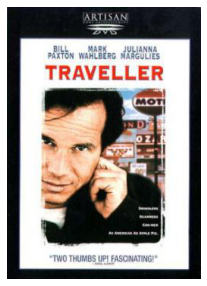

['a', 'young', 'man', ',', 'pat', ',', 'visits', 'the', 'clan', 'of', 'gypsy', '-', 'like', 'gr', '##if', '##ters', '(', 'irish', 'travellers', ')', 'in', 'rural', 'north', 'carolina', 'from', 'whom', 'he', 'is', 'descended', '.', 'he', 'is', 'at', 'first', 'rejected', ',', 'but', 'cousin', 'bo', '##kk', '##y', 'takes', 'him', 'on', 'as', 'an', 'apprentice', '.', 'pat', 'learns', 'the', 'game', 'while', 'bo', '##kk', '##y', 'falls', 'in', 'love', 'and', 'desires', 'a', 'different', 'life', '.']
a young man , pat , visits the clan of gypsy - like grifters ( irish travellers ) in rural north carolina from whom he is descended . he is at first rejected , but cousin bokky takes him on as an apprentice . pat learns the game while bokky falls in love and desires a different life .
['Crime', 'Drama', 'Romance']
Title:  Traveller
Kind:  movie
Year:  1997
Rating:  6.2


In [ ]:
import numpy as np

sample_movieID = 1247
# What is text_mask? 
img, text, text_mask, labels = val_data[sample_movieID]

# Show input image.
plt.figure(figsize=(4,5));plt.imshow(img); plt.axis(False);plt.show()

# Show input plot (untokenized).
tokens = val_data.tokenizer.convert_ids_to_tokens(text, skip_special_tokens = True)
print(tokens)
print(val_data.tokenizer.convert_tokens_to_string(tokens))

# Show target labels (converted back to strings from binary vector).
labels = labels.numpy()
# Is there a better way to do this?
print([val_data.categories[ind] for ind, val in enumerate(labels == 1) if val == 1])

# You can look at other attributes for the movies on this dataset.
movie_metadata = val_data.get_metadata(sample_movieID)
print('Title: ', movie_metadata['smart canonical title'])
print('Kind: ', movie_metadata['kind'])
print('Year: ', movie_metadata['year'])
print('Rating: ', movie_metadata['rating'])

We explore below some of the images in the dataset that belong to the category `Drama`.

There are 1401 movies of type Drama among 2608


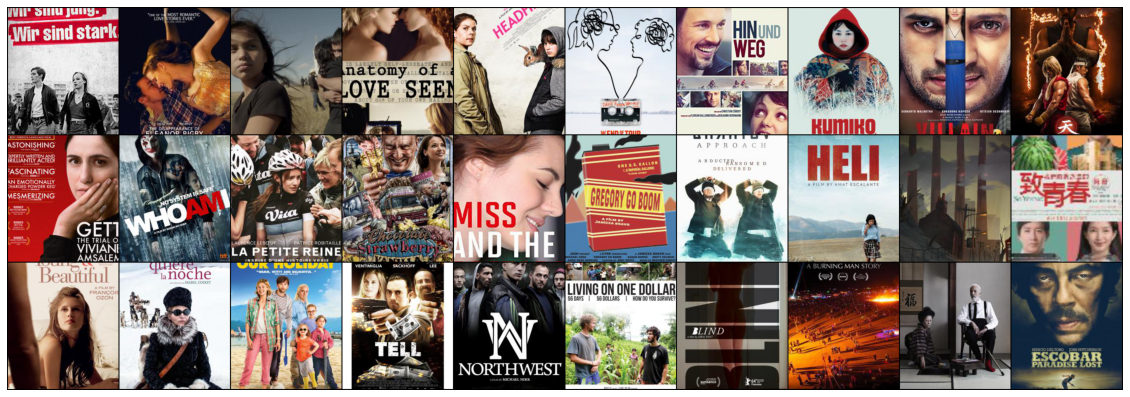

In [14]:
import torchvision
import torchvision.transforms.functional as F
import torchvision.transforms as transforms

# Now let's display a bunch of posters for Crime movies.
movieType = 'Drama'
crime_ids = [id for id in range(0, len(val_data)) \
             if movieType in set(val_data.get_metadata(id)['genres'])]

print('There are %d movies of type %s among %d' % 
      (len(crime_ids), movieType, len(val_data)))

def show_image_group(dataset, image_ids, n_images):
    image_ids = image_ids[:n_images]
    Transf = transforms.Compose([transforms.CenterCrop((256, 224)), transforms.ToTensor()])
    imgs = [Transf(dataset.load_image_only(id)) for id in image_ids]
    grid = torchvision.utils.make_grid(imgs, nrow = 10)
    plt.figure(figsize=(20,10)); plt.axis(False)
    plt.imshow(F.to_pil_image(grid));

# I'm passing the ids in reverse order, because it seems the movies are
# ordered from old to new in the dataset. Try the other way.
show_image_group(val_data, crime_ids[::-1], 30)

#### **2. Classify the Movies into Genres (based on their Plots -- Text Classification) [2pts]**

For this assignment we will not just use BERT encodings but we will use a pretrained BERT model and "fine-tune" its parameters so they adapt to the text in this dataset and learn to give a score for each movie genre to each movie. This is commonly referred as transfer learning just as in the previous assignment but here our data is text. We will ignore the images in the dataset for this section.

##### **2.1. Setting up Data Loaders**

In the code below, we are loading the training, and validation splits and then testing the batch loaders.

In [4]:
# Let's setup the data loaders and preprocessing.
import torchvision.transforms as transforms

# Batch size is a liming factor on constrained resources.
# only GPUs with a large memory can hold large batches.
batch_size = 1

image_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])])

trainset = MovieDataset(split = 'train', image_transform = image_transform)
valset = MovieDataset(split = 'dev', image_transform = image_transform)

train_loader = torch.utils.data.DataLoader(trainset, 
                                           batch_size = batch_size, 
                                           shuffle = True, 
                                           pin_memory = True,
                                           num_workers = 2)
val_loader = torch.utils.data.DataLoader(valset, 
                                         batch_size = batch_size, 
                                         shuffle = False)

Loading dataset-resized-256max/train/metadata ... finished
Tokenizing... finished
Loading dataset-resized-256max/dev/metadata ... finished
Tokenizing... finished


Testing what a sample batch looks like.

In [5]:
(imgs, texts, text_masks, labels) = next(iter(val_loader))
print(imgs.shape, texts.shape, text_masks.shape, labels.shape)

torch.Size([1, 3, 224, 224]) torch.Size([1, 256]) torch.Size([1, 256]) torch.Size([1, 27])


##### **2.2. Loading the predefined BERT Transformer Model**

Here we initialize the pretrained BERT model from the huggingface transformers library. They have several slightly different versions of it that are slightly modified for different tasks so you don't need to manually modify it (e.g. replacing last layer with something else) for your particular task. Do not be surprised if Google Colab keeps crashing. This is a very heavy model so I would recommend only running this cell once. Or if you have to run it twice, you might have to restart the runtime.

In [8]:
from transformers import BertForSequenceClassification, BertConfig

# Defining as global the device to use (by default CPU).
device = torch.device("cuda")

# Loading BERT...
num_categories = len(trainset.categories)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', 
    num_labels = num_categories,  output_attentions = False, 
    output_hidden_states = False)

# Tell pytorch to run this model on the GPU.
model.to(device);

# Let's run a quick test on this model.
output = model(texts, text_masks)
#output = model(texts, text_mask)
print(output.logits.shape)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

torch.Size([1, 27])


##### **2.3. Training Loop for finetuning this BERT Model**
Not very different than a training loop for training a model based on convolutional neural networks. However, please pay close attention to the differences. 

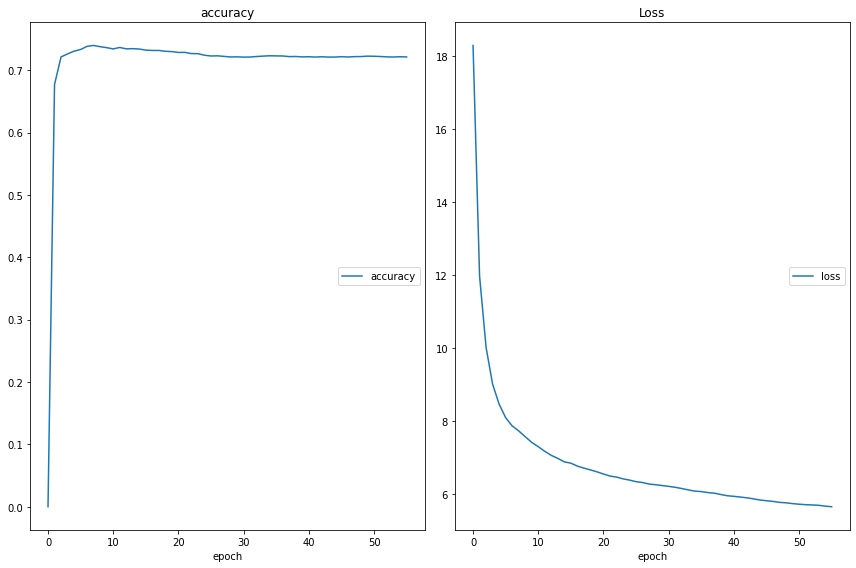

accuracy
	accuracy         	 (min:    0.000, max:    0.740, cur:    0.721)
Loss
	loss             	 (min:    5.646, max:   18.295, cur:    5.646)


KeyboardInterrupt: ignored

In [9]:
from transformers import get_linear_schedule_with_warmup
from livelossplot import PlotLosses
import torch.nn as nn

num_epochs = 4

# Defining as global the device to use (by default CPU).
device = torch.device("cuda")

# Following recommendations from the BERT paper and also this
# blog post https://mccormickml.com/2019/07/22/BERT-fine-tuning/
optimizer = torch.optim.AdamW(model.parameters(), lr = 2e-5, eps = 1e-8)
total_steps = len(train_loader) * num_epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

# Binary Cross-Entroy Loss (BCE Loss).
# Please see documentation here:
# https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html
cost_function = nn.BCEWithLogitsLoss(reduction = 'none')

# Are the top five scored labels accurate?
def top5_accuracy(predicted, labels):
    sorted_vals, sorted_ids = \
        predicted.data.sigmoid().sort(dim = 1, descending = True)
    pred_vals = sorted_vals[:, :5] > 0.5 # Anything with sigmoid > 0.5 is 1.
    true_vals = labels.data.gather(1, sorted_ids[:, :5]) # Find true values.
    return (pred_vals == true_vals).sum(dim = 1) / 5.0
  

# Training Loop. 
best_accuracy = 0
liveloss = PlotLosses(); current_step = 0
for epoch in range(0, num_epochs):
    cumulative_accuracy = 0
    cumulative_loss = 0
    num_samples = 0
    logs = {}
    model.train()
    for (batch_id, (imgs, texts, text_masks, labels)) in enumerate(train_loader):
        # Move to GPU.
        texts = texts.to(device)
        text_masks = text_masks.to(device)
        labels = labels.to(device)

        # Compute predictions.
        predicted = model(texts, text_masks)

        # Compute loss.
        loss = cost_function(predicted.logits, labels)

        # Compute cumulative loss and top-5 accuracy.
        cumulative_loss += loss.data.sum().item()
        cumulative_accuracy += top5_accuracy(predicted.logits, labels).sum().item()
        num_samples += texts.size(0)

        # Backpropagation and SGD update step.
        model.zero_grad()
        loss.mean().backward()
        optimizer.step()
        
        if batch_id % 100 == 0:
            print(epoch, batch_id, cumulative_accuracy / num_samples)
            logs['loss'] = cumulative_loss / num_samples
            logs['accuracy'] = cumulative_accuracy / num_samples
            liveloss.update(logs)
            liveloss.send()
            current_step += 1
    
    cumulative_accuracy = 0
    cumulative_loss = 0
    num_samples = 0
    model.eval()
    with torch.no_grad():
      for (batch_id, (imgs, texts, text_masks, labels)) in enumerate(val_loader):
          # Move to GPU.
          texts = texts.to(device)
          text_masks = text_masks.to(device)
          labels = labels.to(device)

          # Compute predictions.
          predicted = model(texts, text_masks)

          # Compute loss.
          loss = cost_function(predicted.logits, labels)

          # Compute cumulative loss and top-5 accuracy.
          cumulative_loss += loss.data.sum().item()
          cumulative_accuracy += top5_accuracy(predicted.logits, labels).sum().item()
          num_samples += texts.size(0)

          if batch_id % 100 == 0:
              logs['val_loss'] = cumulative_loss / num_samples
              logs['val_accuracy'] = cumulative_accuracy / num_samples    
              liveloss.update(logs, current_step)
              liveloss.send()

    # Advance scheduler.
    if scheduler != -1:
        scheduler.step()

    # Save the parameters for the best accuracy on the validation set so far.
    if logs['val_accuracy'] > best_accuracy:
        best_accuracy = logs['val_accuracy']
        torch.save(model.state_dict(), 'best_model_so_far.pth') 

##### **2.4. Loading model weights from a file**
Training the model in the previous section might take about an hour -- instead we can load a model that has been pretrained already. Feel free to retrain but here I provide a model I trained myself by running the code in the preceding section.

In [ ]:
# I uploaded a "checkpoint" of this model that I trained on Google Drive.
# Try saving and uploading your model to Google Drive as well.
!gdown 1WuLFvQLMd0_Nmpjp7aDRIovWtOiRRyRd
model.load_state_dict(torch.load('best_model_so_far-comp646-spring2022.pth'))
model.eval();

Access denied with the following error:

 	Too many users have viewed or downloaded this file recently. Please
	try accessing the file again later. If the file you are trying to
	access is particularly large or is shared with many people, it may
	take up to 24 hours to be able to view or download the file. If you
	still can't access a file after 24 hours, contact your domain
	administrator. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1WuLFvQLMd0_Nmpjp7aDRIovWtOiRRyRd 



FileNotFoundError: ignored

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive

/content/drive/MyDrive


In [ ]:
!ls

'best_model_so_far-comp646-spring2022 (1).pth'	 Lab-Notebook.ipynb
'Colab Notebooks'				 Lab_Notebook_v2.ipynb


In [ ]:
import torch

model = torch.load('best_model_so_far-comp646-spring2022 (1).pth')

##### **2.5 Show the predictions for a few input texts [1pt]**
Show the top five classification predictions of the BERT model for a few input plots, as shown below. In order to obtain probability scores you need to understand what the nn.BCEWithLogitsLoss is doing when training the prediction scores. Take into account that since we are dealing with multi-class classification, this is not a softmax classifier trained with a cross entropy loss (nn.CrossEntropyLoss), ie. prediction scores don't add up to 1. You also need to know what functions to call to convert the tokenized text back into a regular text.

In [11]:
ids2categories = {}
for keys, values in valset.categories2ids.items():
  ids2categories[values] = keys

In [ ]:
import random
import textwrap
input_list = random.sample(range(0,len(valset)),5)

device = torch.device("cuda")
model.eval()


for idx in input_list:
  print("###########################        INPUT         ############################")
  print("#############################################################################")
  img, text, text_mask, labels = valset[idx]
  wrapped_text = textwrap.fill(valset.texts[idx], width=75)
  print(wrapped_text)
  text = torch.reshape(text,(1,256))#.to(device)
  text_mask = torch.reshape(text_mask,(1,256))#.to(device)
  labels = labels.numpy()
  
  predicted = model(text, text_mask)
  #print(predicted)
  #sorted_vals, sorted_ids = \
  #      predicted.logits.sigmoid().sort(dim = 1, descending = True)
  sorted_vals, sorted_ids =  torch.sigmoid(predicted.logits).sort(dim = 1, descending = True)
  sorted_vals = sorted_vals.detach().numpy()
  sorted_ids = sorted_ids.detach().numpy()
  #print(sorted_vals[0,0].to(device), sorted_ids[0])
  for num in range(5):
    print("P[{0}] = {1:4.3f}".format(ids2categories[sorted_ids[0,num]], sorted_vals[0,num]))
  
  true_labels = [valset.categories[xyz] for xyz in range(len(labels)) if labels[xyz]==1]
  print("Ground True Labels = ", true_labels)


###########################        INPUT         ############################
#############################################################################
Three days into his Miami honeymoon, New York Jewish Lenny meets tall,
blonde Kelly. This confirms him in his opinion that he has made a serious
mistake and he decides he wants Kelly instead. Her rich father is less than
keen and lets everyone - including Lenny - know that he hates everything
about him and the way he is going on.
P[Comedy] = 0.857
P[Drama] = 0.614
P[Romance] = 0.583
P[Musical] = 0.026
P[Family] = 0.020
Ground True Labels =  ['Comedy', 'Drama', 'Romance']
###########################        INPUT         ############################
#############################################################################
An enormous and angry 35 foot Great White Shark takes revenge on humans
when they build a beach just for swimmers by a coastal town. After several
shark attacks, and the Mayor does nothing to stop it, James Frani

##### **2.6. Show the posters for movies rated as Adventure with the highest score by the BERT model. [1pt]**

Use the show_image_group function provided earlier to show the top 30 images scored with the highest scores by the BERT model as ```Adventure```. **Note:** I know the model is not scoring the movies based on the movie poster at all but it seems easier to judge by movie poster for a quick visual inspection as it doesn't require reading text.

{0: 'Action', 1: 'Adult', 2: 'Adventure', 3: 'Animation', 4: 'Biography', 5: 'Comedy', 6: 'Crime', 7: 'Documentary', 8: 'Drama', 9: 'Family', 10: 'Fantasy', 11: 'Film-Noir', 12: 'History', 13: 'Horror', 14: 'Music', 15: 'Musical', 16: 'Mystery', 17: 'News', 18: 'Reality-TV', 19: 'Romance', 20: 'Sci-Fi', 21: 'Short', 22: 'Sport', 23: 'Talk-Show', 24: 'Thriller', 25: 'War', 26: 'Western'}


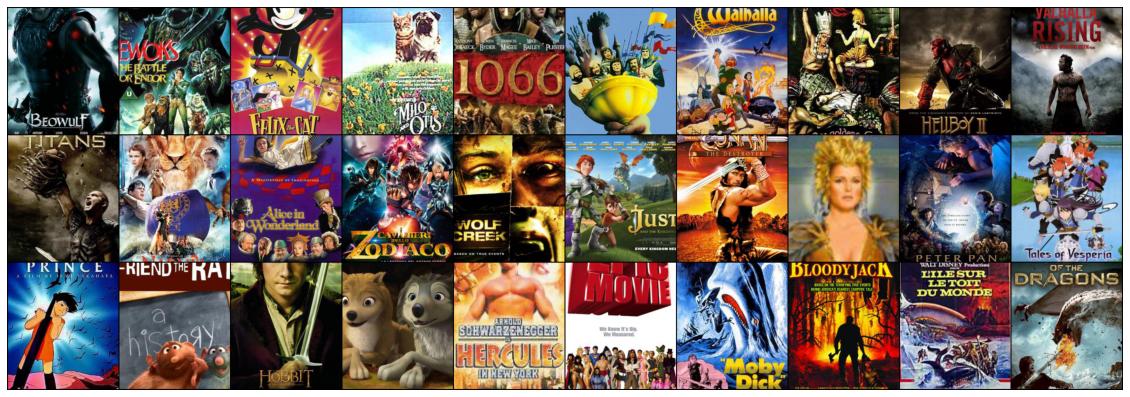

In [15]:
# Your code goes here.
# Now let's display a bunch of posters for Crime movies.
import random
import matplotlib.pyplot as plt

movieType = 'Adventure'
checkid = val_data.categories2ids[movieType]
crime_ids = []
counter = 0
print(ids2categories)
ch = []

while counter <31:
  idx =  random.randrange(0,len(valset))
  img, text, text_mask, labels = valset[idx]
  tokens = val_data.tokenizer.convert_ids_to_tokens(text, skip_special_tokens = True)
  #print(val_data.tokenizer.convert_tokens_to_string(tokens),"\n\n")
  text = torch.reshape(text,(1,256)).to(device)
  text_mask = torch.reshape(text_mask,(1,256)).to(device)

  predicted = model(text, text_mask)
  sorted_vals, sorted_ids = \
        predicted.logits.sigmoid().sort(dim = 1, descending = True)

  sorted_ids = sorted_ids.cpu().detach().numpy()[0,0]
  #print(sorted_ids)
  ch.append(sorted_ids)
  if sorted_ids == checkid and idx not in crime_ids:
    crime_ids.append(idx)
    counter = counter + 1
    #print(counter)
    #print(counter)
  
#plt.hist(ch)
def show_image_group(dataset, image_ids, n_images):
    image_ids = image_ids[:n_images]
    Transf = transforms.Compose([transforms.CenterCrop((256, 224)), transforms.ToTensor()])
    imgs = [Transf(dataset.load_image_only(id)) for id in image_ids]
    grid = torchvision.utils.make_grid(imgs, nrow = 10)
    plt.figure(figsize=(20,10)); plt.axis(False)
    plt.imshow(F.to_pil_image(grid));

# I'm passing the ids in reverse order, because it seems the movies are
# ordered from old to new in the dataset. Try the other way.
show_image_group(valset, crime_ids[::-1], 30)

#please note i am doing random selection


#### **3. Classify the Movies into Genres (based on their Posters -- Images) [2pts]**




In this section we only need to apply what was learned from the previous assignment. The task is to finetune a model to predict these 27 movie genres from the movie poster images. Re-use code from the previous sections, the previous assignment, and the previous assignment solutions, as appropriate. You have to at least show your training/validation accuracy and loss plots showing the model is learning and has converged. Report details of your solution in the [leaderboard](https://docs.google.com/spreadsheets/d/1tzIySUZBZkuxUwplm_-wqdlvPU1x4NqX2vBPvdsluxE/edit?usp=sharing).

In [16]:
# Use a pretrained model for image classification
# Your code goes here.
import torch
#!pip install matplotlib-venn
#!apt-get -qq install -y libfluidsynth1
#!pip install efficientnet_pytorch
import torchvision.models as models

model = models.resnet50(pretrained=True)

# Access the final layer
num_ftrs = model.fc.in_features
# Modify the final layer
model.fc = torch.nn.Sequential(torch.nn.Linear(num_ftrs, 27))
'''
    torch.nn.BatchNorm1d(512),
    torch.nn.ReLU(),
    torch.nn.Linear(512, 256),
    torch.nn.BatchNorm1d(256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 27),
'''

print(num_ftrs)



/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

2048


In [17]:
# data set up
import torchvision.transforms as transforms

# Batch size is a liming factor on constrained resources.
# only GPUs with a large memory can hold large batches.
batch_size = 8

image_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])])

trainset = MovieDataset(split = 'train', image_transform = image_transform)

image_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])])

valset = MovieDataset(split = 'dev', image_transform = image_transform)

train_loader = torch.utils.data.DataLoader(trainset, 
                                           batch_size = batch_size, 
                                           shuffle = True, 
                                           pin_memory = True,
                                           num_workers = 2)
val_loader = torch.utils.data.DataLoader(valset, 
                                         batch_size = batch_size, 
                                         shuffle = False)

Loading dataset-resized-256max/train/metadata ... finished
Tokenizing... finished
Loading dataset-resized-256max/dev/metadata ... finished
Tokenizing... finished


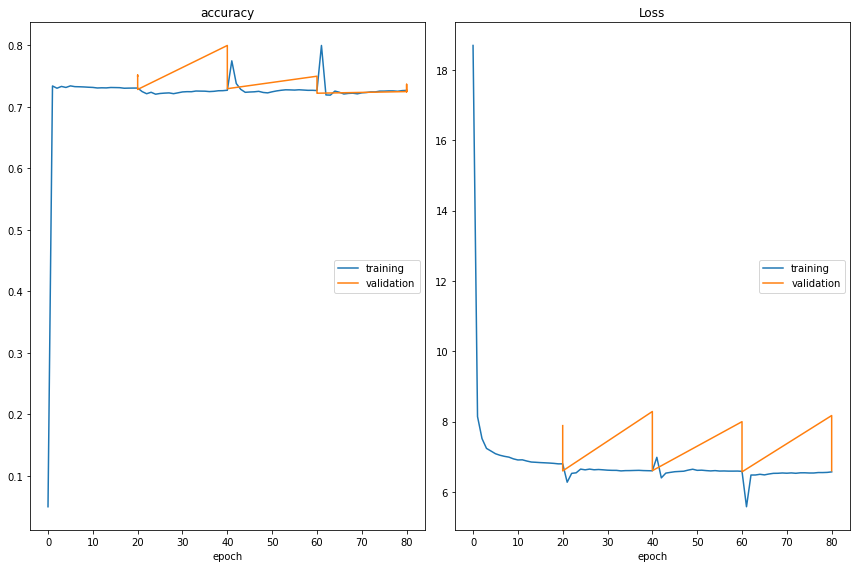

accuracy
	training         	 (min:    0.050, max:    0.800, cur:    0.727)
	validation       	 (min:    0.722, max:    0.800, cur:    0.727)
Loss
	training         	 (min:    5.578, max:   18.697, cur:    6.569)
	validation       	 (min:    6.571, max:    8.286, cur:    6.602)


In [18]:
from transformers import get_linear_schedule_with_warmup
from livelossplot import PlotLosses
import torch.nn as nn
from sklearn.metrics import precision_score, recall_score, f1_score

num_epochs = 4
batch_size = 8
recall = 0
precision = 0
f1score = 0
counter = 0


device = torch.device("cuda")
optimizer = torch.optim.AdamW(model.parameters(), lr = 2e-2, eps = 1e-8)
total_steps = len(train_loader) * num_epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps = 0, num_training_steps = total_steps)
model.to(device);
cost_function = nn.BCEWithLogitsLoss(reduction = 'none')

# Are the top five scored labels accurate?
def top5_accuracy(predicted, labels):
    sorted_vals, sorted_ids = \
        predicted.data.sigmoid().sort(dim = 1, descending = True)
    pred_vals = sorted_vals[:, :5] > 0.5 # Anything with sigmoid > 0.5 is 1.
    true_vals = labels.data.gather(1, sorted_ids[:, :5]) # Find true values.
    return (pred_vals == true_vals).sum(dim = 1) / 5.0


# Training Loop. 
best_accuracy = 0
liveloss = PlotLosses(); current_step = 0
for epoch in range(0, num_epochs):
    cumulative_accuracy = 0
    cumulative_loss = 0
    num_samples = 0
    logs = {}
    model.train()
    for (batch_id, (imgs, texts, text_masks, labels)) in enumerate(train_loader):
        # Move to GPU.
        imgs = imgs.to(device)
        labels = labels.to(device)

        # Compute predictions.
        predicted = model(imgs)
        #print(predicted, labels)
        # Compute loss.
        loss = cost_function(predicted, labels)

        
        # Compute cumulative loss and top-5 accuracy.
        cumulative_loss += loss.data.sum().item()
        cumulative_accuracy += top5_accuracy(predicted, labels).sum().item()
        num_samples += texts.size(0)

        # Backpropagation and SGD update step.
        model.zero_grad()
        loss.mean().backward()
        optimizer.step()
        
        if batch_id % 100 == 0:
            print(epoch, batch_id, cumulative_accuracy / num_samples)
            logs['loss'] = cumulative_loss / num_samples
            logs['accuracy'] = cumulative_accuracy / num_samples
            liveloss.update(logs)
            liveloss.send()
            current_step += 1
    
    cumulative_accuracy = 0
    cumulative_loss = 0
    num_samples = 0
    model.eval()
    with torch.no_grad():
      for (batch_id, (imgs, texts, text_masks, labels)) in enumerate(val_loader):
          # Move to GPU.
          imgs = imgs.to(device)
          labels = labels.to(device)

          # Compute predictions.
          predicted = model(imgs)

          # Compute loss.
          loss = cost_function(predicted, labels)

          # Compute cumulative loss and top-5 accuracy.
          cumulative_loss += loss.data.sum().item()
          cumulative_accuracy += top5_accuracy(predicted, labels).sum().item()
          
          if epoch ==3:
            if counter == 0:
              pre = predicted
              lab = labels
            counter = counter + 1
            pre = torch.cat((pre, predicted), dim=0)
            lab = torch.cat((lab, labels), dim=0)          
          num_samples += texts.size(0)

          if batch_id % 100 == 0:
              logs['val_loss'] = cumulative_loss / num_samples
              logs['val_accuracy'] = cumulative_accuracy / num_samples    
              liveloss.update(logs, current_step)
              liveloss.send()

    # Advance scheduler.
    if scheduler != -1:
        scheduler.step()

    # Save the parameters for the best accuracy on the validation set so far.
    if logs['val_accuracy'] > best_accuracy:
        best_accuracy = logs['val_accuracy']
        torch.save(model.state_dict(), 'best_model_so_far.pth')
        print("Saving the best model")

#print("Final recall:", recall/counter*100)
#print("Final precision:", precision/counter*100)
#print("Final f1score:",  2 * precision * recall / (precision + recall)/counter*100)



In [19]:
#print(predicted)
xyz= pre.data.sigmoid()
pred = xyz.cpu().numpy().flatten() > 0.5
tru = lab.cpu().numpy().flatten() 
recall = recall_score(tru, pred, zero_division = 1)
precision = precision_score(tru, pred, zero_division = 1)
f1score = f1_score(tru, pred)
print("Final recall:", recall)
print("Final precision:", precision)
print("Final f1score:",  f1score)

#please note, recall rate is fluctuating for each run by 10-20 points.


Final recall: 0.21517241379310345
Final precision: 0.536697247706422
Final f1score: 0.30718739744010504


**Required answer:** Is this model better than the text classifier in terms of top-5 accuracy as computed earlier? Which one is better?

This model is generating better validation accuracy compared to the text classifier. But only by 6-8 points. So it is not a major difference in regards to top 5 accuracy , especailly it is only one validation data set we are comparing. We should use other KPIs like F1score, recall and precision to conclude better

#### **4. Zero-shot Text Classification with FLAN-T5 [3pts]**

Some really impressive tools have been developed in the past few years with transformer neural networks. Auto-regressive neural networks allow one to predict the next element in a sequence given the previous elements. We can cast almost any problem involving text in this way. Recently Google released [FLAN-T5](https://arxiv.org/pdf/2210.11416.pdf), a powerful language model that on top of being pre-trained to predict the next word in a sequence, it was finetuned to follow instructions for a variety of tasks. The following figure shows some examples:
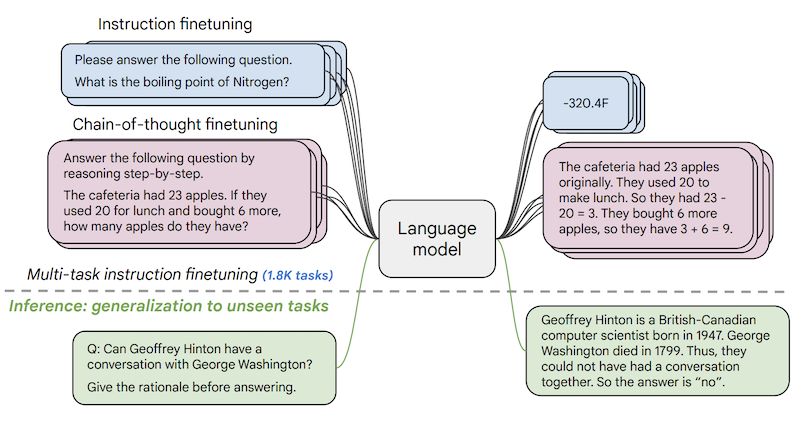


This network is included in the Hugginface transformers 🤗 library and you can try it interactively here: https://huggingface.co/google/flan-t5-xl

Use this network to predict the genre of the movies from the MMIMDB dataset and report your best accuracy in this leaderboard. **Note:** You are not allowed to train this network, you should use the network as-is. You need to design a classifier that can tell you the genre of the movie given a movie plot purely using this language model to give you the answers and some scores. Please use the link above to try different ideas. Report your top5 accuracy as computed earlier in the assignment for the Movie Plot classification task here in this [leaderboard](https://docs.google.com/spreadsheets/d/1AQRakP32IWAbtRcH97sBhosDXHC2iLvLtAv9K1Ou92I/edit?usp=sharing). [To get full points obtain more than TBA% top-5 accuracy].

In [ ]:
!pip -q install transformers==4.26.0
!pip -q install sentencepiece
!pip -q install accelerate

In [ ]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

# Load the language model and its tokenizer.
tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-xl")
model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-xl", device_map="auto")

# Load a smaller language model if the above proves hard during development.
#tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-small")
#model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-small", device_map="auto")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Replace the cell below with your solution, you need to report the top5 accuracy of your method as computed in section 2. 

In [ ]:
input_text = '''Translate this text to German: 
                Text: The more you run the healthier you become
                Answer:'''
input_ids = tokenizer(input_text, return_tensors="pt").input_ids.to("cuda")
outputs = model.generate(input_ids, max_new_tokens = 20, output_scores = True, return_dict_in_generate = True)

# You can also obtain the output scores (probabilities) over the vocabulary
# by looking into outputs.scores
print(tokenizer.decode(outputs.sequences[0]))

<pad> Text: Die mehr Sie laufen, die stärkste Sie werden</s>


In [ ]:
# Load the validation dataset, no need to load training set since no training is allowed.
valset = MovieDataset(split = 'dev', tokenizer = None)

Loading dataset-resized-256max/dev/metadata ... finished
Tokenizing... finished


In [ ]:
print(valset.categories)


['Action', 'Adult', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'Film-Noir', 'History', 'Horror', 'Music', 'Musical', 'Mystery', 'News', 'Reality-TV', 'Romance', 'Sci-Fi', 'Short', 'Sport', 'Talk-Show', 'Thriller', 'War', 'Western']


In [ ]:
# Your code to predict movie genres goes here.
import numpy as np
device = torch.device("cuda")
#tokenizer2 = BertTokenizer.from_pretrained('bert-base-uncased')

true_cor = 0
true_fal = 0
fal_fal = 0
fal_cor = 0
acc = 0
epso = 0.0000001

def top5_accuracy(predicted, labels, acc, true_cor, true_fal,fal_fal, fal_cor):
    buffer = 0
    for idx in range(27):
      if predicted[idx]==labels[idx] and predicted[idx]==1:
        true_cor = true_cor + 1
      elif predicted[idx]==labels[idx] and predicted[idx]==0:
        true_fal = true_fal + 1
      elif predicted[idx] == 0:
        fal_cor = fal_cor + 1
      else:
        fal_fal = fal_fal + 1
    if np.sum(predicted) < 5 and np.sum(labels)< 5:
      buffer = min(5-np.sum(predicted), 5-np.sum(labels))
    acc = min(np.count_nonzero(np.add(predicted,labels)==2)+ buffer,5) + acc
    return acc, true_cor,true_fal,fal_fal, fal_cor

for idx in range(len(valset)):
  img, text, labels = valset[idx]
  text2 = "what are the 5 categories for the movie plot:"
  text3 = "categories are: ['Action', 'Adult', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'Film-Noir', 'History', 'Horror', 'Music', 'Musical', 'Mystery', 'News', 'Reality-TV', 'Romance', 'Sci-Fi', 'Short', 'Sport', 'Talk-Show', 'Thriller', 'War', 'Western']"
  text = text2 + " " + text + " " + text3
  input_ids = tokenizer(text, return_tensors="pt").input_ids.to("cuda")
  outputs = model.generate(input_ids, max_new_tokens = 20, output_scores = True, return_dict_in_generate = True)
  list1 = tokenizer.decode(outputs.sequences[0]).replace(" ","").replace("<pad>","").replace("</s>","").split(',')
  #print(list1)
  #print([valset.categories[ind] for ind, val in enumerate(labels == 1) if val == 1])

  x =[valset.categories2ids[list1[num]] for num in range(len(list1)) if list1[num] in valset.categories]
  #print(x)
  np1 = np.zeros(27)
  for num in range(27):
    if num in x:
      np1[num] =1
  
  #print(x,"\n",np1,"\n",labels)
  acc, true_cor, true_fal,fal_fal, fal_cor = top5_accuracy(np1, labels.numpy(),acc,true_cor, true_fal,fal_fal, fal_cor)
  #print(idx)
  #print(acc,true_cor, true_fal,fal_fal, fal_cor )
  precision = true_cor/ (true_cor + fal_fal+ epso)
  recall = true_cor /(true_cor + fal_cor + epso)
  #print(precision, recall)
  f1score = 2 * (precision * recall) / (precision + recall+epso)

acc = acc /(5*len(valset))*100
print(acc,true_cor, true_fal,fal_fal, fal_cor,5*len(valset))
print("Final accuracy  :", acc)
print("Final precision :", precision *100)
print("Final Recall    :", recall *100)
print("Final F1score   :", f1score *100)

'''
  print([valset.categories[ind] for ind, val in enumerate(labels == 1) if val == 1])
  movie_metadata = valset.get_metadata(idx)
  print('Title: ', movie_metadata['smart canonical title'])
  print('Kind: ', movie_metadata['kind'])
  print('Year: ', movie_metadata['year'])
  print('Rating: ', movie_metadata['rating'])
'''






Token indices sequence length is longer than the specified maximum sequence length for this model (581 > 512). Running this sequence through the model will result in indexing errors


61.832822085889575 2433 60152 3758 4073 13040
Final accuracy  : 61.832822085889575
Final precision : 39.298982393162674
Final Recall    : 37.39624961516452
Final F1score   : 38.32400854898147


"\n  print([valset.categories[ind] for ind, val in enumerate(labels == 1) if val == 1])\n  movie_metadata = valset.get_metadata(idx)\n  print('Title: ', movie_metadata['smart canonical title'])\n  print('Kind: ', movie_metadata['kind'])\n  print('Year: ', movie_metadata['year'])\n  print('Rating: ', movie_metadata['rating'])\n"

#### **5. Zero-shot Image Classification with CLIP [3pts]**



In January 2021, OpenAI published a research paper named CLIP ([Contrastive Language-Image Pretraining](https://arxiv.org/abs/2103.00020)) https://openai.com/blog/clip/. This model was trained to maximize the dot product between vector representations of text and images that have a direct correspondence and minimize their dot product when they do not correspond. One key property of this model is that it can be used to build zero-shot classifier. Since the model was trained on a large number of images and text from the web, this model knows about a lot of categories of things. Your goal in this section is to obtain the best results using the illustrated approach in this figure for the scene classification problem of Assignment 1 (SUN20). Please enter the best classification accuracy in the [leaderboard](https://docs.google.com/spreadsheets/d/1Xj1GHNHHlErx4a5O0OngCI13sfPqCkwg1PCFQEqnEAA/edit?usp=sharing) here using CLIP. [To get full points obtain more than 92% accuracy]

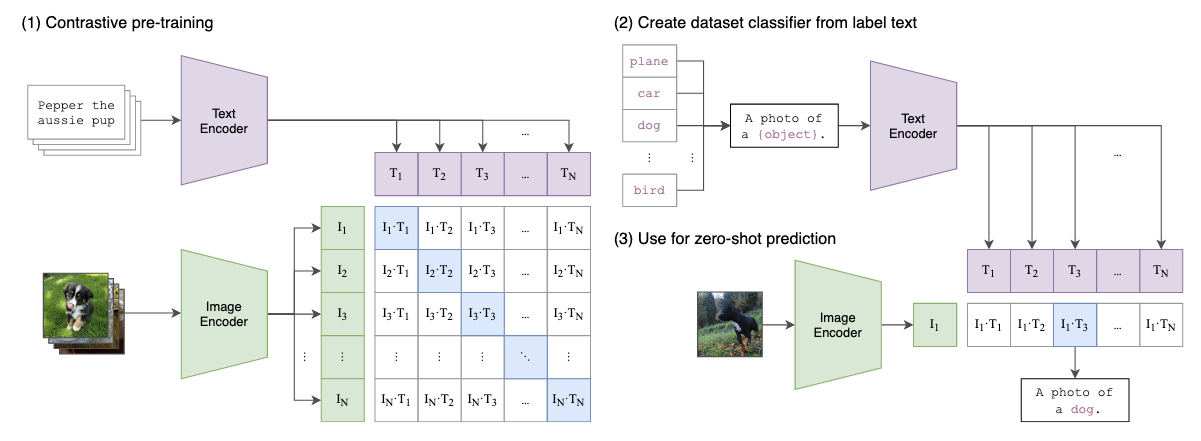

In [ ]:
# Your code goes here
# This command downloads the files with the prepackaged contents.
!wget -nc http://www.cs.rice.edu/~vo9/deep-vislang/SUN20-train-sm.tar.gz
!wget -nc http://www.cs.rice.edu/~vo9/deep-vislang/SUN20-val.tar.gz
!tar xf SUN20-train-sm.tar.gz
!tar xf SUN20-val.tar.gz
!cat SUN20/train/ClassName.txt




File ‘SUN20-train-sm.tar.gz’ already there; not retrieving.

File ‘SUN20-val.tar.gz’ already there; not retrieving.

/a/arch
/b/bathroom
/b/butte
/d/dentists_office
/h/hot_spring
/j/jacuzzi/indoor
/l/lighthouse
/l/laundromat
/l/lecture_room
/l/living_room
/l/library/indoor
/m/mansion
/m/marsh
/m/mountain
/s/sauna
/s/shower
/s/skyscraper
/t/tower
/t/tree_house
/v/volcano


In [ ]:
import os, json, pickle, random
import torch.utils.data
from PIL import Image

# Simple implementation of a custom data loading class for our SUN20 dataset.
class SUN20(torch.utils.data.Dataset):

  # Initialize the class e.g. load files, preprocess, etc.
  def __init__(self, split = 'train', transform = None):
    
    # These are the 20 categories selected.
    self.categories = open('SUN20/' + split + '/ClassName.txt').read().split('\n')[:-1]
    self.categories = sorted(self.categories)
    self.category2index = {category: idx for (idx, category) in enumerate(self.categories)}
    self.transform = transform

    # Compile a list of images and corresponding labels.
    self.imagepaths = []
    self.labels = []
    for category in self.categories:
      category_directory = 'SUN20/' + split + category
      category_imagenames = os.listdir(category_directory)
      self.imagepaths += [os.path.join(category_directory, imagename) 
                          for imagename in category_imagenames]
      self.labels += [self.category2index[category]] * len(category_imagenames)

    # Sort imagepaths alphabetically and labels accordingly.
    sorted_pairs = sorted(zip(self.imagepaths, self.labels), key = lambda x: x[0])
    self.imagepaths, self.labels = zip(*sorted_pairs)

        
  # Return a sample (x, y) as a tuple e.g. (image, label)
  def __getitem__(self, index):
    image = Image.open(self.imagepaths[index]).convert('RGB')
    if self.transform:
      image = self.transform(image)
    return image, self.labels[index]
  
  # Return the total number of samples.
  def __len__(self):
    return len(self.imagepaths)

import matplotlib
import matplotlib.pyplot as plt

trainset = SUN20(split = 'train')
valset = SUN20(split = 'val')
labels = valset.categories

In [ ]:
#!pip install --yes -c pytorch pytorch torchvision cudatoolkit = 11.0
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

import torch
import clip
from PIL import Image

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-85asxh67
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-85asxh67
  Resolved https://github.com/openai/CLIP.git to commit 3702849800aa56e2223035bccd1c6ef91c704ca8
  Preparing metadata (setup.py) ... done


In [ ]:
#!pip install transformers
#!pip install --upgrade transformers

import torch
import numpy as np
from PIL import Image
import torchvision.transforms as transforms

device = "cuda" # if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)


print(labels)

labels = valset.categories
labels = ["a photo of " + num[3:].replace("/"," ") for num in labels]
images = []
true_labels = []
print(len(valset))
for idx in range(len(valset)):
  img, lab = valset[idx]
  img = preprocess(img).to(device)
  images.append(img)
  true_labels.append(lab)

print(images[1].shape)

labels1 = clip.tokenize(labels).to(device)

# Encode the image
image_tensor = torch.stack([image for image in images])
print(image_tensor.shape)
with torch.no_grad():
    image_features = model.encode_image(image_tensor)
    text_features = model.encode_text(labels1)
    logits_per_image, logits_per_text = model(image_tensor, labels1)
    prob = logits_per_image.softmax(dim=-1).cpu().numpy()

print(prob)
acc = 0
for idx in range(len(valset)):
  if labels[prob[idx].argmax()] == labels[true_labels[idx]]:
    acc =acc +1
  
print("Final Accuracy:", acc/1000*100)




['a photo of arch', 'a photo of bathroom', 'a photo of butte', 'a photo of dentists_office', 'a photo of hot_spring', 'a photo of jacuzzi indoor', 'a photo of laundromat', 'a photo of lecture_room', 'a photo of library indoor', 'a photo of lighthouse', 'a photo of living_room', 'a photo of mansion', 'a photo of marsh', 'a photo of mountain', 'a photo of sauna', 'a photo of shower', 'a photo of skyscraper', 'a photo of tower', 'a photo of tree_house', 'a photo of volcano']
1000
torch.Size([3, 224, 224])
torch.Size([1000, 3, 224, 224])
[[7.090e-01 2.141e-02 3.664e-03 ... 8.337e-02 1.465e-04 1.795e-04]
 [9.971e-01 1.073e-06 2.148e-03 ... 3.293e-04 4.768e-07 9.537e-07]
 [3.677e-01 3.818e-02 6.844e-03 ... 1.981e-02 5.445e-04 5.193e-04]
 ...
 [4.246e-04 1.323e-05 2.308e-04 ... 6.211e-05 2.086e-06 9.858e-01]
 [7.796e-05 8.345e-07 2.327e-04 ... 1.369e-04 2.778e-05 9.937e-01]
 [1.514e-05 1.371e-06 8.540e-04 ... 4.315e-05 1.192e-06 9.966e-01]]
Final Accuracy: 92.2
